In [1]:
working_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics"
data_dir = "/data/projects/dschaub/ANCA-GN_transcriptomics/data/single-cell/ustekinumab"

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

os.chdir(working_dir)

import yaml
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import mudata as md
import muon as mu
import numpy as np
import scanpy as sc
from matplotlib import gridspec
import scanpy.external as sce
from scipy import sparse
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

from utils.utils import *
from utils.plotting import *

sc.settings.verbosity = 0
sc.set_figure_params(dpi=80)
sns.set(style="white")

Global seed set to 0
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/conda/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [3]:
path = os.path.join(data_dir, "ANCA_ustekinumab_4PK4PB_Tcells.h5mu")
anca_data = md.read_h5mu(path)
anca_data

MuData object with n_obs × n_vars = 34810 × 38528
  obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_CITE', 'nFeature_CITE', 'frac.mito', 'frac.ribo', 'Feature_Count_ratio', 'CD3_count', 'RNA_snn_res.0.1', 'seurat_clusters', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'patient', 'sample', 'case', 'tissue', 'RNA_snn_res.0.5', 'RNA_snn_res.0.7', 'RNA_snn_res.0.8', 'RNA_snn_res.0.9', 'RNA_snn_res.1', 'cell_type', 'Trm_score1', 'non_Trm_score2', 'CD4_Trm_score3', 'CD4_non_Trm_score4', 'CD8_Trm_score5', 'CD8_non_Trm_score6', 'Proinflam_cytokines_score7'
  obsm:	'X_harmony', 'X_pca', 'X_umap'
  3 modalities
    RNA:	34810 x 38224
      layers:	'counts'
    CITE:	34810 x 302
      layers:	'counts'
    HTO:	34810 x 2
      layers:	'counts'

In [5]:
relevant_obs = ["patient", "sample", "tissue", "case", "orig.ident", "cell_type"]
anca_data.obs = anca_data.obs[relevant_obs]

In [6]:
mod = "RNA"
rna_data = ad.AnnData(
    anca_data.mod[mod].layers["counts"].copy(),
    # obs=anca_data.obs.copy(),
    var=anca_data.mod[mod].var[[]],
    layers={"counts": anca_data.mod[mod].layers["counts"].copy()},
    obsm={
        "X_harmony": anca_data.obsm["X_harmony"].copy(),
        "X_umap": anca_data.obsm["X_umap"].copy(),
    },
)

In [7]:
mod = "CITE"
cite_data = ad.AnnData(
    anca_data.mod[mod].layers["counts"].copy(),
    # obs=anca_data.obs.copy(),
    var=anca_data.mod[mod].var[[]],
    layers={"counts": anca_data.mod[mod].layers["counts"].copy()},
    obsm={
        "X_harmony": anca_data.obsm["X_harmony"].copy(),
        "X_umap": anca_data.obsm["X_umap"].copy(),
    },
)

In [8]:
rna_data.obs = anca_data.obs.copy()
cite_data.obs = anca_data.obs.copy()

## Futher processing

In [9]:
print(len(cite_data.var_names))
var_names = [name for name in cite_data.var_names if not "Hash" in name]
cite_data = cite_data[:, var_names].copy()
sc.pp.filter_genes(cite_data, min_cells=10)
print(len(cite_data.var_names))

302
228


In [10]:
mod_cite = cite_data

get_adata_stats(mod_cite)

min cells per sample: 321,
max cells per sample: 13909,
min n expressed genes per cell: 10,
max n expressed genes per cell: 147,
min n cells expressing gene: 14



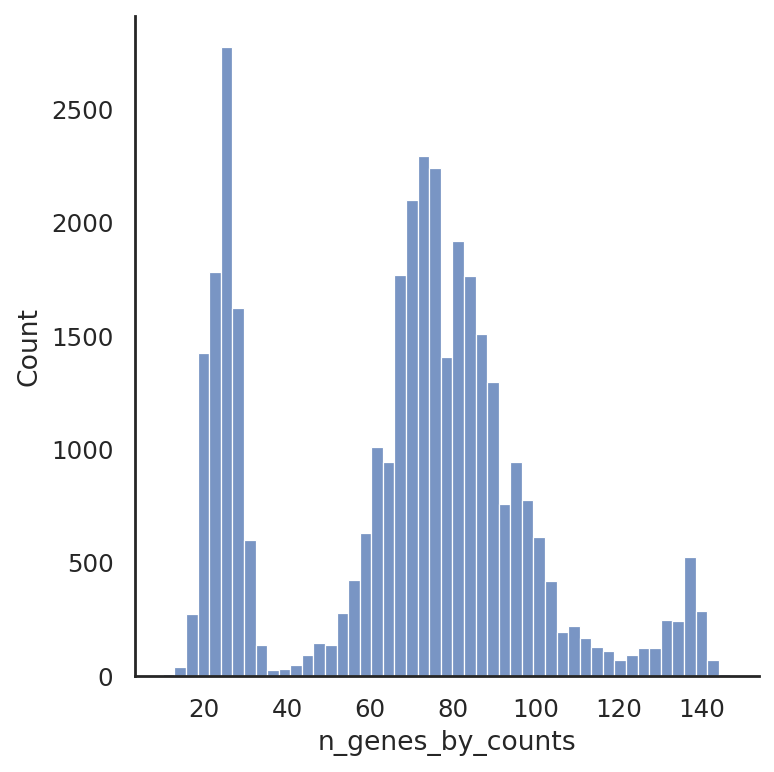

In [11]:
sc.pp.calculate_qc_metrics(mod_cite, inplace=True, percent_top=None)
sns.displot(mod_cite.obs.n_genes_by_counts)

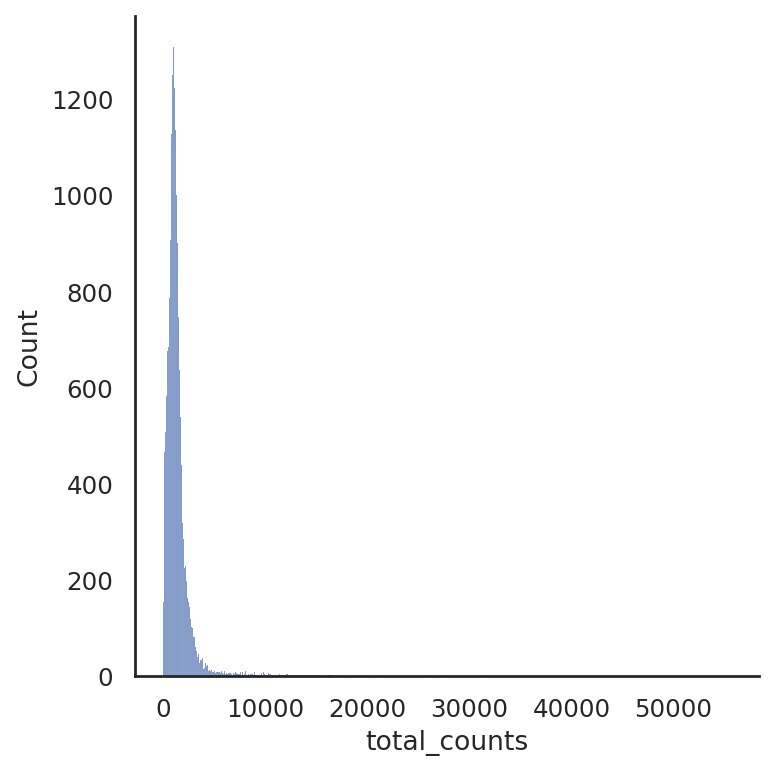

In [12]:
sns.displot(mod_cite.obs.total_counts)

In [13]:
log_normalize(rna_data)
protein_clr(cite_data)

scale(rna_data)
scale(cite_data)

In [14]:
rna_data.X = rna_data.layers["log1p"].copy()
cite_data.X = cite_data.layers["clr"].copy()

## Refine annotation

In [15]:
rna_data.obs.cell_type.value_counts()

CD4_EM/RM    6832
CD4_Naive    6802
Treg         3894
CD8_EM/RM    3706
CD4_CM/EM    3641
CD4_CM       2716
NKT/gdT      2670
CD8_Naive    1035
CD8_CTL       989
CD4_CTL       908
NKT           756
MAIT          591
Prolif        270
Name: cell_type, dtype: int64

In [16]:
mapping = {
    "CD4_EM/RM": "CD4+ Teff",
    "CD8_EM/RM": "CD8+ Teff",
    "CD4_CM/EM": "CD4+ Tcm/Tem",
    "CD4_CM": "CD4+ Tcm",
    "CD4_Naive": "CD4+ naive",
    "CD8_Naive": "CD8+ naive",
    "Treg": "Treg",
    "MAIT": "MAIT/gdT",
    "CD4_CTL": "CD4+ CTL",
    "CD8_CTL": "NKT",
    "NKT/gdT": "NKT",
    "NKT": "NKT",
    "Prolif": "Prolif",
}
rna_data.obs["cell_type_v1"] = (
    rna_data.obs["cell_type"].astype(str).replace(mapping).astype("category")
)

## Save everything

In [17]:
anca_data_clean = md.MuData(
    {
        "rna": rna_data.copy(),
        "cite": cite_data.copy(),
    }
)

# save data
save_path = os.path.join(data_dir, "ANCA_ustekinumab_4PK4PB_Tcells_annotated.h5mu")
anca_data_clean.write_h5mu(save_path)

... storing 'patient' as categorical
... storing 'sample' as categorical
... storing 'tissue' as categorical
... storing 'case' as categorical
... storing 'orig.ident' as categorical
... storing 'patient' as categorical
... storing 'sample' as categorical
... storing 'tissue' as categorical
... storing 'case' as categorical
... storing 'orig.ident' as categorical
